In [1]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import csv
import io
from past.builtins import unicode
import argparse
import logging
import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from io import StringIO
import os
import logging
import pandas as pd
from biosppy.signals import ecg
import sys

TARGET_SAMPLING_RATE=250
DATA_SAMPLING_RATE=500
INPUT_BEAT_SIZE=300

In [ ]:
csv_row='germany,HR00003,HR00003.csv,37.0,F,"norm,sr",german,0,1,1,300002,300002'
patinet_attributes_list=next(csv.reader(StringIO(csv_row), quotechar='"', delimiter=',',quoting=csv.QUOTE_MINIMAL, skipinitialspace=True))
patient_id=patinet_attributes_list[11]
age=patinet_attributes_list[3]
gender=patinet_attributes_list[9]
diagnosis=patinet_attributes_list[10]
race=patinet_attributes_list[8]
file_name=patinet_attributes_list[2]


In [ ]:
path =  '/Users/aring/IdeaProjects/ECG-biometric/src/100k-data/sample-data/germany/DenData/'+file_name


In [ ]:
all_beats_12lead_with_label_diagnosis = np.empty((0,12,INPUT_BEAT_SIZE+5), dtype=np.float)


In [ ]:
record = pd.read_csv(path, header=None)
record.head()

In [ ]:
channel = record[1].values
channel

In [ ]:
ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
rpeaks=ecg_info_extracted['rpeaks']
rpeaks
        

In [ ]:
one_beat=record[:][rpeaks[1]:rpeaks[1+1]]

In [ ]:
one_beat.shape

In [ ]:
down_sampled_beat = signal.resample(one_beat, 300)
down_sampled_beat.shape

In [ ]:
np.reshape(down_sampled_beat,(1,INPUT_BEAT_SIZE,12)).shape

In [ ]:
heart_beats_12lead =  np.empty((0,12,INPUT_BEAT_SIZE), dtype=np.float)

for i in range((len(rpeaks)-1)):
    down_sampled_beat = signal.resample(record[:][rpeaks[i]:rpeaks[i+1]], 300).T
    heart_beats_12lead=np.vstack((heart_beats_12lead,np.reshape(down_sampled_beat,(1,12,INPUT_BEAT_SIZE))))

In [80]:
heart_beats_12lead.shape

(9, 12, 300)

In [81]:
num_of_beats=heart_beats_12lead.shape[0]

In [ ]:
plt.plot( heart_beats_12lead[1,:,:]) 


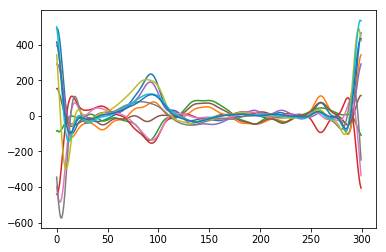

In [79]:
for i in range(0,11):
    plt.plot( heart_beats_12lead[1,i,:]) 

plt.show()

In [85]:
all_beats_12lead_with_label_diagnosis = np.empty((0,12,INPUT_BEAT_SIZE+5), dtype=np.float)

for i in range(0,num_of_beats):
    one_beat_12lead = np.reshape(heart_beats_12lead[i], (12, 300))
    label_column = np.repeat(patient_id, one_beat_12lead.shape[0])
    label_column=np.reshape(label_column, (label_column.shape[0], 1))
    diagnosis_column=np.repeat(diagnosis, one_beat_12lead.shape[0])
    diagnosis_column=np.reshape(diagnosis_column, (diagnosis_column.shape[0], 1))
    age_column=np.repeat(age, one_beat_12lead.shape[0])
    age_column=np.reshape(age_column, (age_column.shape[0], 1))
    gender_column=np.repeat(gender, one_beat_12lead.shape[0])
    gender_column=np.reshape(gender_column, (gender_column.shape[0], 1))
    race_column=np.repeat(race, one_beat_12lead.shape[0])
    race_column=np.reshape(race_column, (race_column.shape[0], 1))
    one_beat_12lead_with_label = np.append(one_beat_12lead,label_column,1)
    one_beat_12lead_with_label = np.append(one_beat_12lead_with_label,diagnosis_column,1)
    one_beat_12lead_with_label = np.append(one_beat_12lead_with_label,age_column,1)
    one_beat_12lead_with_label = np.append(one_beat_12lead_with_label,gender_column,1)
    one_beat_12lead_with_label = np.append(one_beat_12lead_with_label,race_column,1)
    one_beat_12lead_with_label = np.reshape(one_beat_12lead_with_label,(1,12,305))
    all_beats_12lead_with_label_diagnosis=np.vstack((all_beats_12lead_with_label_diagnosis,one_beat_12lead_with_label))


In [86]:
all_beats_12lead_with_label_diagnosis.shape

(9, 12, 305)

In [91]:
all_beats_12lead_with_label_diagnosis

array([], shape=(0, 305), dtype='<U32')

#### splitting to train and test

In [2]:

def split_train_test_for_identification(all_data_df,patientid_column_num):
    df_by_patinetid=all_data_df.groupby(all_data_df.columns[patientid_column_num]).size().reset_index(name='count')
    df_by_patinetid.columns=['patient_id','heartbeat_count']
    patients_beatnum_dict=df_by_patinetid.to_dict('record')
    num_of_patients_processed=0
    for row in patients_beatnum_dict:
        if row['heartbeat_count']>4:
            patients_beats_data=all_data_df.loc[all_data_df[all_data_df.columns[patientid_column_num]]==row['patient_id']]
            num_test_beats=int(row['heartbeat_count']*.2)
            random_rows=np.random.choice(row['heartbeat_count'], size=num_test_beats, replace=False)
            test_for_patient=patients_beats_data.iloc[random_rows,:]
            train_for_patient=patients_beats_data.drop(patients_beats_data.index[random_rows])
            if num_of_patients_processed>0:
                train=train.append(train_for_patient)
                test=test.append(test_for_patient)
            else:
                train=train_for_patient
                test=test_for_patient

            num_of_patients_processed=num_of_patients_processed+1
    return (train,test)



In [3]:
file_path='/Users/aring/IdeaProjects/ECG-biometric/src/100k-data/sample-data/output-dataflow-00000-of-00001.csv'
df=pd.read_csv(file_path, delimiter=',', header=None)
train,test=split_train_test_for_identification(df,3655)

In [4]:
train.shape

(38, 3660)

In [5]:
test.shape

(7, 3660)